In [1]:
%run ../supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Diffusion model

### What is Diffusion model?
A diffusion model is a type of generative model used to create data such as images. Generation begins with random noise, but this is gradually refined over a number of steps until an output image emerges. At each step, the model estimates how we could go from the current input to a completely denoised version. 

### How Diffusion Models Work?
The core idea behind diffusion models is based on a two-phase process:

- Forward Process (Noising):
This phase involves gradually adding noise to an image (or any data) over multiple steps until the image becomes pure noise. This process is usually done in a controlled manner, so the noise is added gradually over many steps, making it possible to reverse it later.
In simpler terms, you take a clean image and progressively "destroy" it by adding random noise, until it becomes pure random noise.

- Reverse Process (Denoising):
In this phase, the model learns to reverse the noise process. Starting from pure random noise, the model tries to gradually remove the noise in such a way that it generates a new, realistic image that fits the training data.
This process is the "generative" part, where the model generates new data by learning how to iteratively denoise random noise, producing data that looks like the samples it was trained on.

This code is inspired from [HuggingFace's examples for diffusion model](https://huggingface.co/docs/diffusers/en/using-diffusers/merge_loras)

## Using Pre-trained Diffusion model to generate Image according to the prompt

### Importing the necessary libraries

In [9]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

In [10]:
# Check if CUDA (GPU) is available
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load the pre-trained model

In [29]:
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Define prompts

In [30]:
prompts = [
    "A cute golden retriever puppy playing with a red ball",
    "A library in a cave, lit by glowing crystals",
    "A polar bear swimming in pool",
    "An enchanted forest with glowing mushrooms"
]

### Generate images

  0%|          | 0/50 [00:00<?, ?it/s]

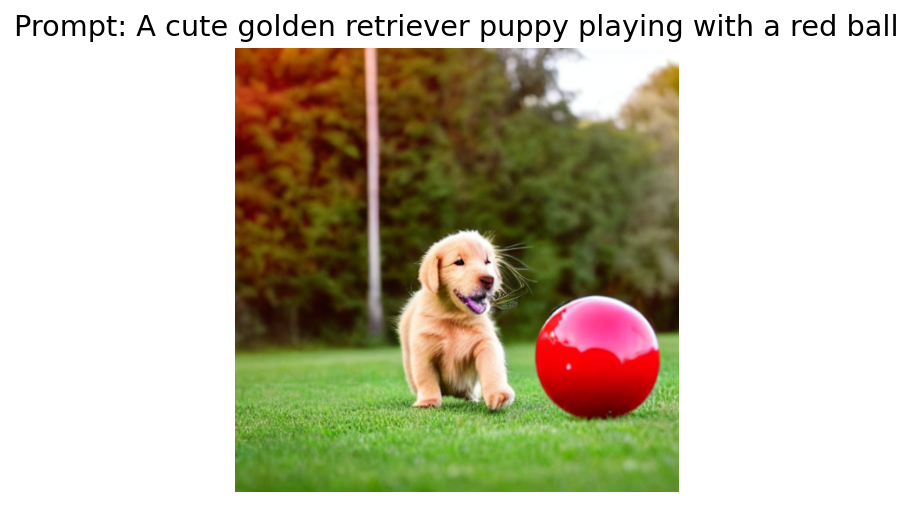

  0%|          | 0/50 [00:00<?, ?it/s]

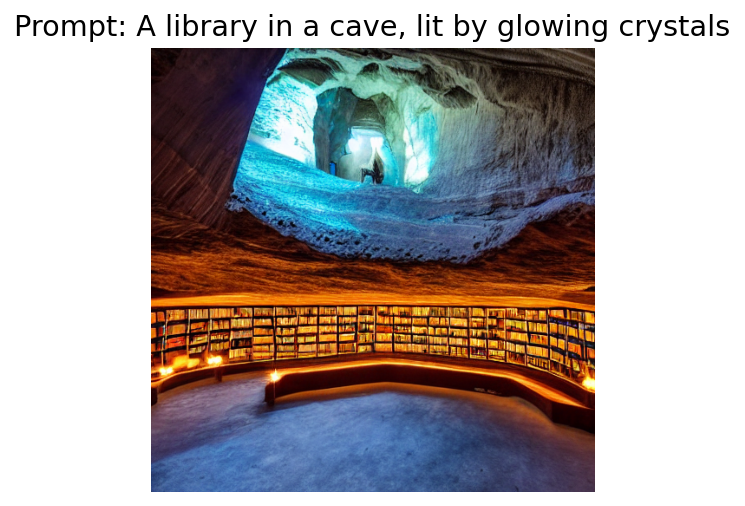

  0%|          | 0/50 [00:00<?, ?it/s]

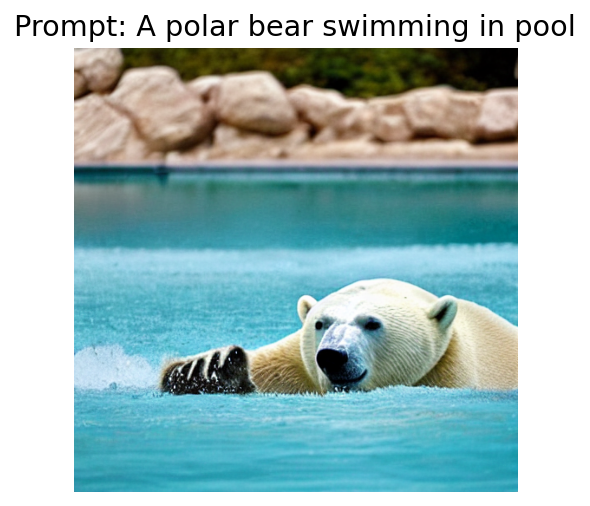

  0%|          | 0/50 [00:00<?, ?it/s]

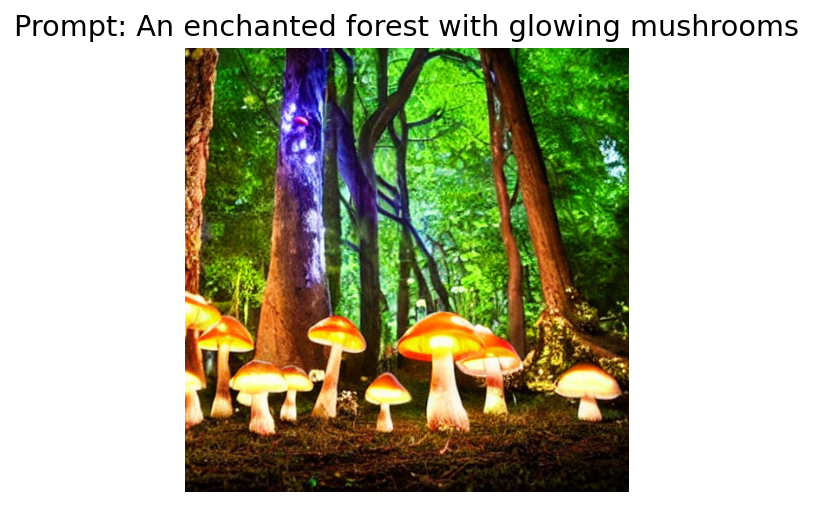

: 

In [ ]:
# Generate and display images for each prompt
for i, prompt in enumerate(prompts):
    output = pipe(
        prompt=prompt, 
        guidance_scale=8,  # How closely to follow the prompt
        num_inference_steps=50  # Number of denoising steps
    )
    image = output.images[0]
    
    # Display the image with the prompt as the caption
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prompt: {prompt}")  
    plt.show()  

## Using Pre-trained Diffusion Model with LoRA Adapters to Generate Image According to Prompt

In [1]:
from diffusers import DiffusionPipeline
import torch

# Load the base pipeline
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16).to("cuda")

2024-11-21 00:40:02.236230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 00:40:02.257838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 00:40:02.264483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 00:40:02.281987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 00:40:03.464129: W tensorflow/compiler/tf2

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
# Load the LoRA weights
pipeline.load_lora_weights("TheLastBen/Papercut_SDXL", weight_name="papercut.safetensors", adapter_name="papercut")
pipeline.load_lora_weights("alvdansen/soft-focus-3d", weight_name="araminta_k_soft_focus_3d.safetensors", adapter_name="art")

# Set the generator for reproducibility
generator = torch.manual_seed(0)

# Define the prompt
prompt = "A portrait of a woman in a forest at twilight, in paper-cut style with a soft-focus 3D background"

### Generating image using only the base model 

Generating with base model only...


  0%|          | 0/50 [00:00<?, ?it/s]

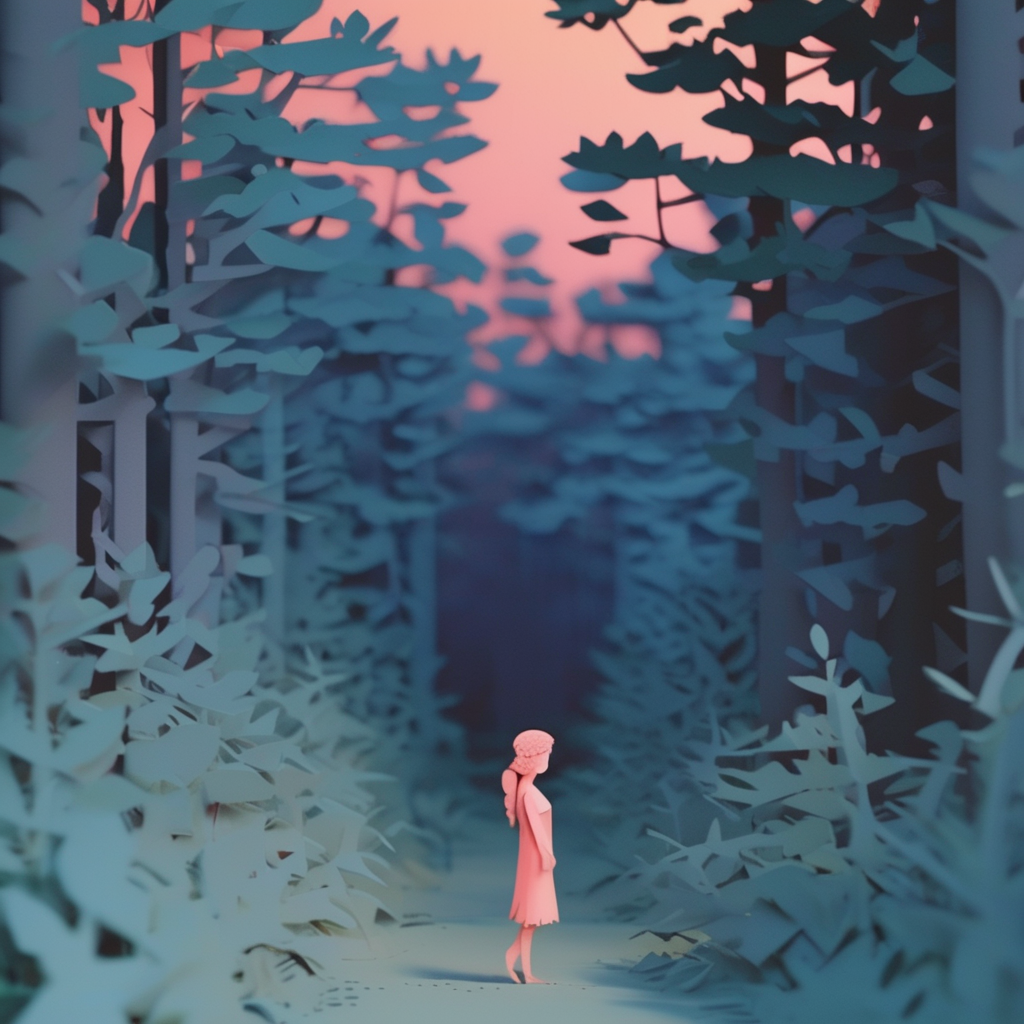

In [3]:
# Run with base model only
print("Generating with base model only...")
pipeline._lora_scale = None  # Disable LoRA entirely for this step
image_base = pipeline(prompt, generator=generator, cross_attention_kwargs={"scale": 1.0}).images[0]
image_base

### Generating the image using base model and papercut lora adapter

Generating with 'papercut' adapter...


  0%|          | 0/50 [00:00<?, ?it/s]

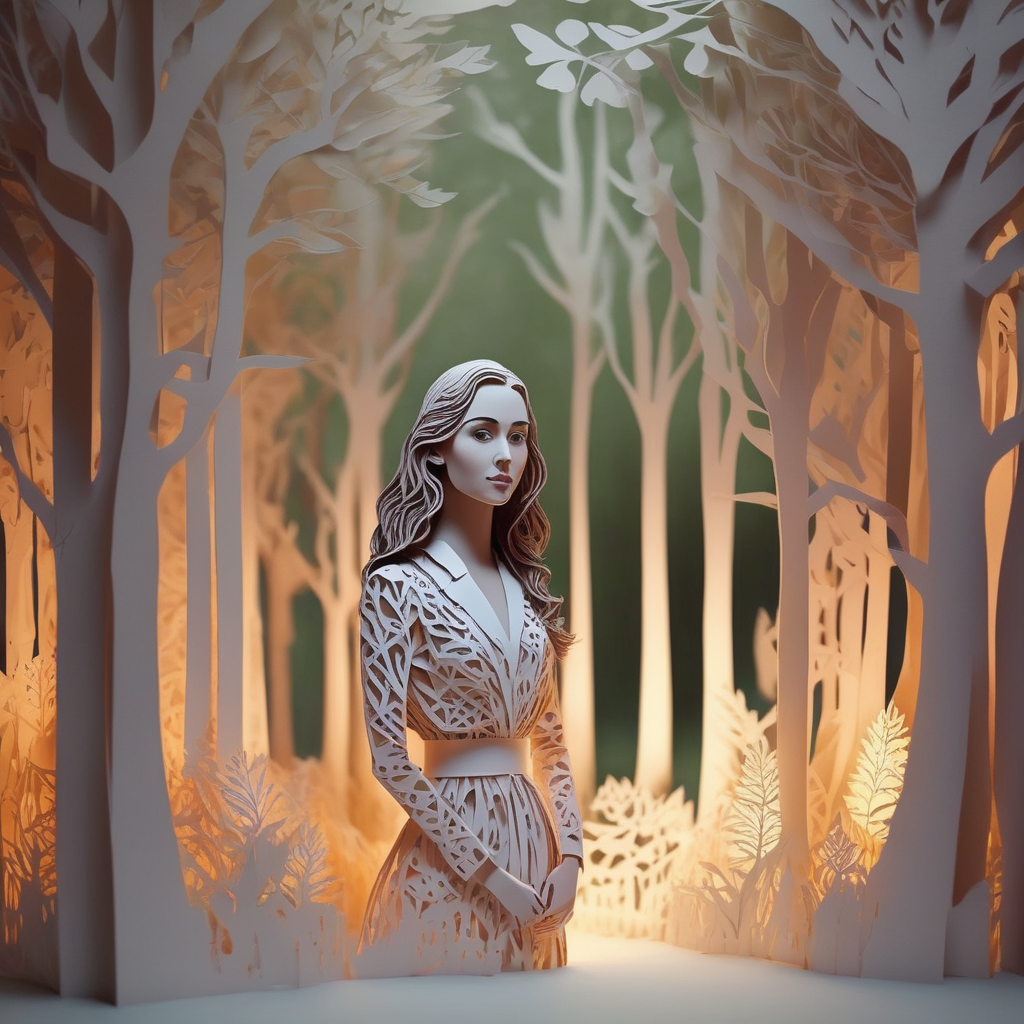

In [9]:
# Run with one LoRA adapter
print("Generating with 'papercut' adapter...")
pipeline.set_adapters(["papercut"], adapter_weights=[0.8])
image_papercut = pipeline(prompt, generator=generator, cross_attention_kwargs={"scale": 1.0}).images[0]
image_papercut

### Generating the image using base model and both lora adapters

Generating with 'papercut' and 'art' adapters...


  0%|          | 0/50 [00:00<?, ?it/s]

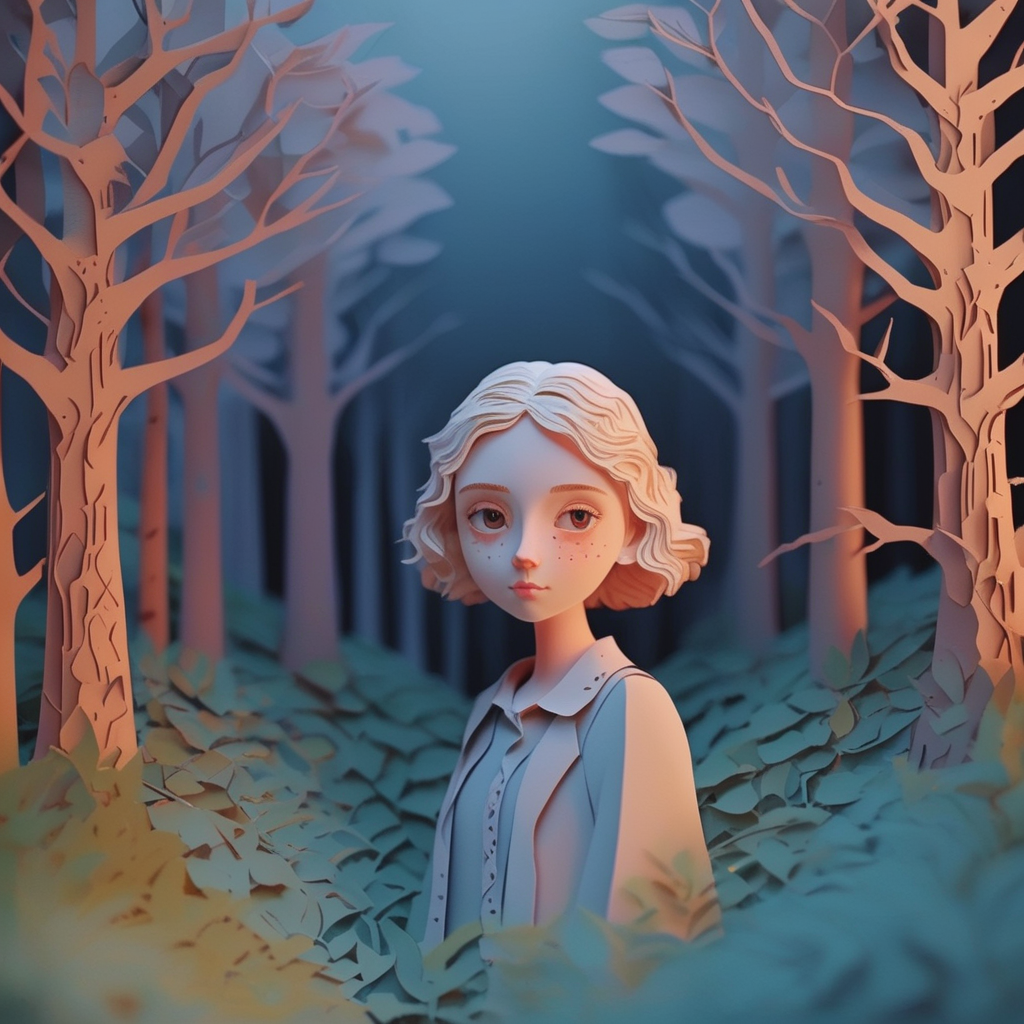

In [5]:
# Run with both LoRA adapters
print("Generating with 'papercut' and 'art' adapters...")
pipeline.set_adapters(["papercut", "art"], adapter_weights=[0.7, 0.8])
image_combined = pipeline(prompt, generator=generator, cross_attention_kwargs={"scale": 1.0}).images[0]
image_combined